<font size="5">Import Libraries</font>

In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings("ignore")

# Set seaborn style for visualizations
sb.set(rc={'figure.figsize': (12,7)})

# Enable garbage collection
gc.enable()

# Collect garbage
gc.collect()

0

In [2]:
# Load dataset
star = pd.read_csv('/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv')

# Collect garbage
gc.collect()

21

First few rows:


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10)

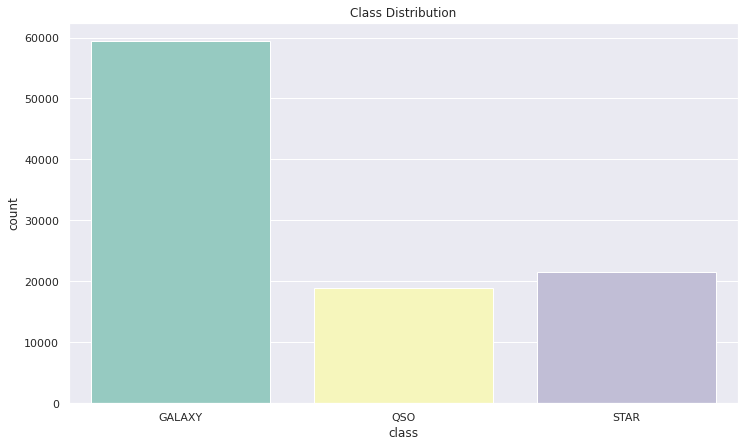

2656

In [3]:
# Display first few rows
print("First few rows:")
display(star.head())

# Data info and null check
print("Data Info:")
star.info()
print("Null Values:")
print(star.isnull().sum())

# Class distribution
print("Class Distribution:")
print(star["class"].value_counts(normalize=True) * 100)

# Plot class distribution
sb.countplot(x=star["class"], palette="Set3")
plt.title("Class Distribution")
plt.show()

# Encode class labels for later use
le = LabelEncoder()
star["class"] = le.fit_transform(star["class"])

# Collect garbage
gc.collect()


In [4]:
# Remove outliers using IQR method
def rem_outliers(df):
    s1 = df.shape
    for i in df.select_dtypes(include='number').columns:
        qt1 = df[i].quantile(0.25)
        qt3 = df[i].quantile(0.75)
        iqr = qt3 - qt1
        lower = qt1 - (1.5 * iqr)
        upper = qt3 + (1.5 * iqr)
        min_in = df[df[i] < lower].index
        max_in = df[df[i] > upper].index
        df.drop(min_in, inplace=True)
        df.drop(max_in, inplace=True)
    s2 = df.shape
    outliers = s1[0] - s2[0]
    return outliers

outliers_removed = rem_outliers(star)
print(f"Number of outliers deleted: {outliers_removed}")

# Drop unnecessary columns
columns_to_drop = ['run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'fiber_ID', 'obj_ID']
star.drop(columns_to_drop, axis=1, inplace=True)

# Split features and target
X = star.drop('class', axis=1)
y = star['class']

# Train-validation-test split (60% train, 20% validation, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Standardize features
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(sc.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)

# Apply SMOTE to training set
oversampler = SMOTE(random_state=1)
X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)

# Collect garbage
gc.collect()

Number of outliers deleted: 14266


48

In [5]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Collect garbage
gc.collect()

21

In [6]:
# Define traditional ML models (CPU/GPU where supported)
models = {
    'Linear SVC': LinearSVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'CatBoost': CatBoostClassifier(task_type='GPU' if torch.cuda.is_available() else 'CPU', verbose=0),
    'LightGBM': LGBMClassifier(device='gpu' if torch.cuda.is_available() else 'cpu')
}

# Function to print evaluation metrics
def print_metrics(y_true, y_pred, dataset_name, model_name):
    print(f"\n{model_name} on {dataset_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.2f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.2f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='macro'):.2f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

# Train and evaluate traditional ML models
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    print(f"{name} trained.")
    
    # Training metrics
    y_train_pred = model.predict(X_train_smote)
    print_metrics(y_train_smote, y_train_pred, "Training Set", name)
    
    # Validation metrics
    y_val_pred = model.predict(X_val)
    print_metrics(y_val, y_val_pred, "Validation Set", name)
    
    # Collect garbage
    gc.collect()

# Define neural network with CUDA optimization
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize neural network on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn_model = SimpleNN(input_size=X_train.shape[1], num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Train neural network with validation
num_epochs = 10
for epoch in range(num_epochs):
    nn_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = nn_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    # Validation
    nn_model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = nn_model(X_val_batch)
            _, predicted = torch.max(val_outputs.data, 1)
            val_total += y_val_batch.size(0)
            val_correct += (predicted == y_val_batch).sum().item()
    val_accuracy = 100 * val_correct / val_total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    # Collect garbage
    gc.collect()

Linear SVC trained.

Linear SVC on Training Set:
Accuracy: 93.22%
Precision: 0.93
Recall: 0.93
F1-Score: 0.93
Confusion Matrix:
[[29159  3575   605]
 [ 2404 30919    16]
 [  177     8 33154]]

Linear SVC on Validation Set:
Accuracy: 91.25%
Precision: 0.85
Recall: 0.93
F1-Score: 0.88
Confusion Matrix:
[[9820 1145  174]
 [ 146 1813    3]
 [  30    3 4013]]
Decision Tree trained.

Decision Tree on Training Set:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Confusion Matrix:
[[33339     0     0]
 [    0 33339     0]
 [    0     0 33339]]

Decision Tree on Validation Set:
Accuracy: 95.13%
Precision: 0.91
Recall: 0.94
F1-Score: 0.92
Confusion Matrix:
[[10557   567    15]
 [  243  1718     1]
 [    9     0  4037]]
Random Forest trained.

Random Forest on Training Set:
Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Confusion Matrix:
[[33338     1     0]
 [    0 33339     0]
 [    0     0 33339]]

Random Forest on Validation Set:
Accuracy: 97.49%
Precision: 0.96
R

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LightGBM trained.

LightGBM on Training Set:
Accuracy: 97.99%
Precision: 0.98
Recall: 0.98
F1-Score: 0.98
Confusion Matrix:
[[32586   727    26]
 [ 1256 32082     1]
 [    3     0 33336]]

LightGBM on Validation Set:
Accuracy: 96.95%
Precision: 0.94
Recall: 0.96
F1-Score: 0.95
Confusion Matrix:
[[10795   290    54]
 [  163  1797     2]
 [   14     0  4032]]
Epoch 1/10, Loss: 0.0610, Validation Accuracy: 94.44%
Epoch 2/10, Loss: 0.2571, Validation Accuracy: 94.58%
Epoch 3/10, Loss: 0.3419, Validation Accuracy: 95.81%
Epoch 4/10, Loss: 0.0863, Validation Accuracy: 95.49%
Epoch 5/10, Loss: 0.0970, Validation Accuracy: 95.02%
Epoch 6/10, Loss: 0.1310, Validation Accuracy: 95.11%
Epoch 7/10, Loss: 0.0543, Validation Accuracy: 95.46%
Epoch 8/10, Loss: 0.0553, Validation Accuracy: 95.35%
Epoch 9/10, Loss: 0.1563, Validation Accuracy: 95.67%
Epoch 10/10, Loss: 0.0188, Validation Accuracy: 95.75%


In [7]:
# Define custom VotingClassifier to handle prediction shape
class CustomVotingClassifier(VotingClassifier):
    def _predict(self, X):
        predictions = [est.predict(X).ravel() for est in self.estimators_]
        return np.asarray(predictions).T

# Define voting classifier
voting_clf = CustomVotingClassifier(estimators=[
    ('svc', models['Linear SVC']),
    ('dt', models['Decision Tree']),
    ('rf', models['Random Forest']),
    ('catboost', models['CatBoost']),
    ('lgbm', models['LightGBM'])
], voting='hard')

# Train voting classifier
voting_clf.fit(X_train_smote, y_train_smote)
print("Voting Classifier trained.")

# Training metrics
y_train_pred_voting = voting_clf.predict(X_train_smote)
print_metrics(y_train_smote, y_train_pred_voting, "Training Set", "Voting Classifier")

# Validation metrics
y_val_pred_voting = voting_clf.predict(X_val)
print_metrics(y_val, y_val_pred_voting, "Validation Set", "Voting Classifier")

# Collect garbage
gc.collect()

Voting Classifier trained.

Voting Classifier on Training Set:
Accuracy: 99.17%
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
Confusion Matrix:
[[33022   293    24]
 [  513 32825     1]
 [    0     0 33339]]

Voting Classifier on Validation Set:
Accuracy: 97.29%
Precision: 0.95
Recall: 0.96
F1-Score: 0.96
Confusion Matrix:
[[10846   246    47]
 [  171  1790     1]
 [    0     0  4046]]


52

In [8]:
# Voting Classifier predictions on test set
y_test_pred_voting = voting_clf.predict(X_test)
print("\nVoting Classifier Test Set Predictions:")
print_metrics(y_test, y_test_pred_voting, "Test Set", "Voting Classifier")

# Neural Network predictions on test set
nn_model.eval()
y_test_pred_nn = []
y_true_nn = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = nn_model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_test_pred_nn.extend(predicted.cpu().numpy())
        y_true_nn.extend(y_batch.numpy())
print("\nNeural Network Test Set Predictions:")
print_metrics(y_true_nn, y_test_pred_nn, "Test Set", "Neural Network")

# Collect garbage
gc.collect()


Voting Classifier Test Set Predictions:

Voting Classifier on Test Set:
Accuracy: 97.04%
Precision: 0.94
Recall: 0.96
F1-Score: 0.95
Confusion Matrix:
[[10759   303    45]
 [  158  1723     1]
 [    0     0  4158]]

Neural Network Test Set Predictions:

Neural Network on Test Set:
Accuracy: 95.71%
Precision: 0.92
Recall: 0.96
F1-Score: 0.94
Confusion Matrix:
[[10523   398   186]
 [  148  1732     2]
 [    2     0  4156]]


24

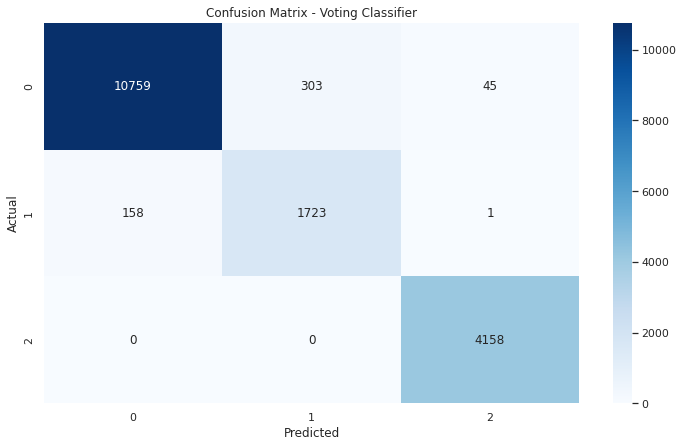

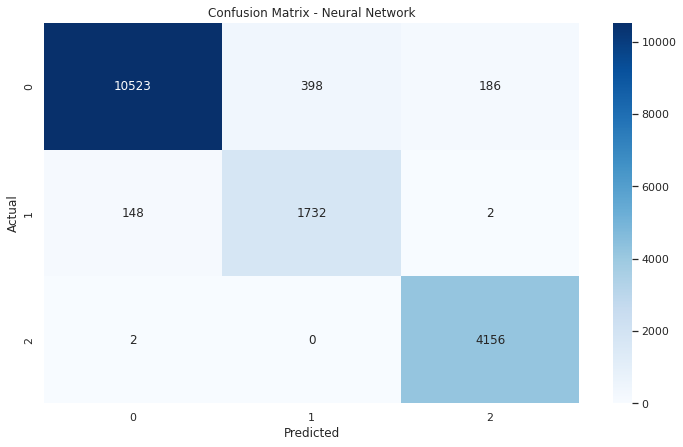

10394

In [9]:
# Confusion matrix for Voting Classifier
y_pred_voting = voting_clf.predict(X_test)
cm_voting = confusion_matrix(y_test, y_pred_voting)
sb.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Voting Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for Neural Network
nn_model.eval()
y_pred_nn = []
y_true_nn = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = nn_model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_nn.extend(predicted.cpu().numpy())
        y_true_nn.extend(y_batch.numpy())
cm_nn = confusion_matrix(y_true_nn, y_pred_nn)
sb.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Collect garbage
gc.collect()

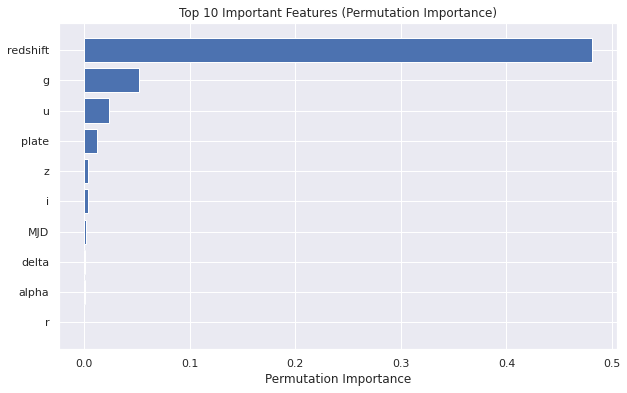

Feature Importance Scores:
redshift: 0.4808
g: 0.0520
u: 0.0232
plate: 0.0117
z: 0.0035
i: 0.0031
MJD: 0.0013
delta: 0.0007
alpha: 0.0005
r: -0.0000


3822

In [10]:
# Compute permutation importance
result = permutation_importance(voting_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Extract and sort feature importances
feature_names = X_test.columns
importances = result.importances_mean
sorted_idx = importances.argsort()[::-1]

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx][:10], importances[sorted_idx][:10])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Important Features (Permutation Importance)')
plt.gca().invert_yaxis()
plt.show()

# Print all feature importances
print("Feature Importance Scores:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Collect garbage
gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

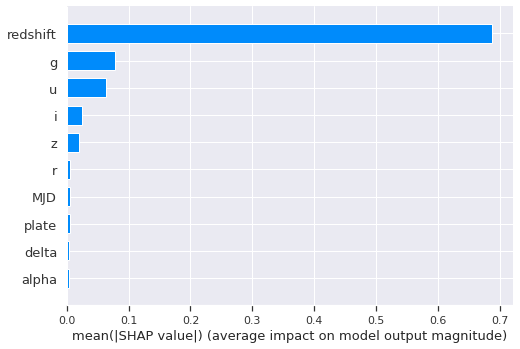

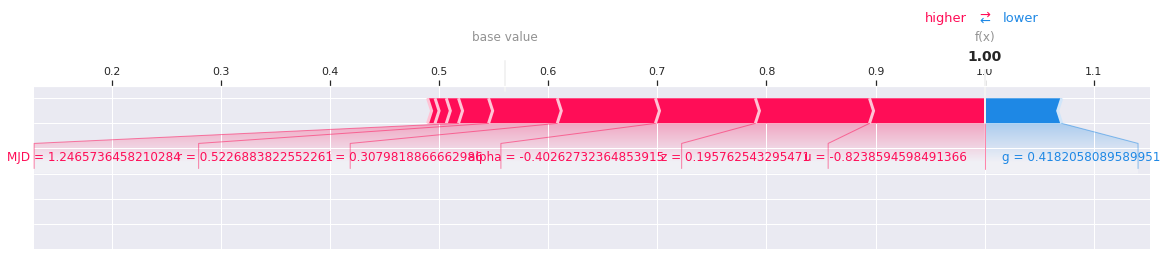

10839

In [11]:
# Select a random subset of 100 samples from test set
subset_size = 100
X_test_subset = X_test.sample(subset_size, random_state=42)

# Define prediction function for SHAP
def predict_fn(X):
    return voting_clf.predict(X)

# Use KernelExplainer for SHAP
explainer = shap.KernelExplainer(predict_fn, X_train_smote[:100])  # Small background set
shap_values = explainer.shap_values(X_test_subset)

# Summary plot
shap.summary_plot(shap_values, X_test_subset, plot_type="bar")

# Force plot for first instance
shap.force_plot(explainer.expected_value, shap_values[0], X_test_subset.iloc[0], matplotlib=True)

# Collect garbage
gc.collect()

In [12]:
# Simulate new data (5 samples from test set)
new_data = X_test.sample(5, random_state=42)

# In practice, apply scaler to new data if not pre-scaled
new_data_scaled = sc.transform(new_data) 

# Predict using VotingClassifier
new_predictions = voting_clf.predict(new_data)
new_predictions_labels = le.inverse_transform(new_predictions)

# Display predictions
print("\nInference Pipeline Results:")
for i, pred in enumerate(new_predictions_labels):
    print(f"Sample {i+1}: Predicted Class = {pred}")

# Collect garbage
gc.collect()


Inference Pipeline Results:
Sample 1: Predicted Class = QSO
Sample 2: Predicted Class = GALAXY
Sample 3: Predicted Class = STAR
Sample 4: Predicted Class = GALAXY
Sample 5: Predicted Class = GALAXY


28